In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

In [2]:
IMAGE_DIR = 'Mirai1_Data/Mirai1_3_data_timed_circles_1600'

# List all the feature images and sort them
X1_images = sorted([img for img in os.listdir(IMAGE_DIR) if img.startswith('X_1')])
X2_images = sorted([img for img in os.listdir(IMAGE_DIR) if img.startswith('X_2')])
X3_images = sorted([img for img in os.listdir(IMAGE_DIR) if img.startswith('X_3')])
label_images = sorted([img for img in os.listdir(IMAGE_DIR) if img.startswith('Y')])

# Group feature images (X1_i, X2_i, X3_i)
feature_images = list(zip(X1_images, X2_images, X3_images))

# Define a custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, feature_images, label_images, transform=None):
        self.feature_images = feature_images
        self.label_images = label_images
        self.transform = transform

    def __len__(self):
        return len(self.feature_images)

    def __getitem__(self, idx):
        feature_img_paths = [os.path.join(IMAGE_DIR, img_name) for img_name in self.feature_images[idx]]
        label_img_path = os.path.join(IMAGE_DIR, self.label_images[idx])

        feature_imgs = [plt.imread(img_path)[:, :, 0] for img_path in feature_img_paths]  # Take only the first channel for each image
        label_img = plt.imread(label_img_path)[:, :, 0]                                    # Take only the first channel

        if self.transform:
            feature_imgs = torch.stack([self.transform(img) for img in feature_imgs], dim=0)
            label_img = self.transform(label_img)

        return feature_imgs, label_img

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = CustomDataset(feature_images, label_images, transform=transform)


In [3]:
print(len(dataset))

1600


In [4]:
# Split the dataset into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)


In [5]:
data, target = train_dataset[0]
print(data.shape)
print(target.shape)

torch.Size([3, 1, 50, 50])
torch.Size([1, 50, 50])


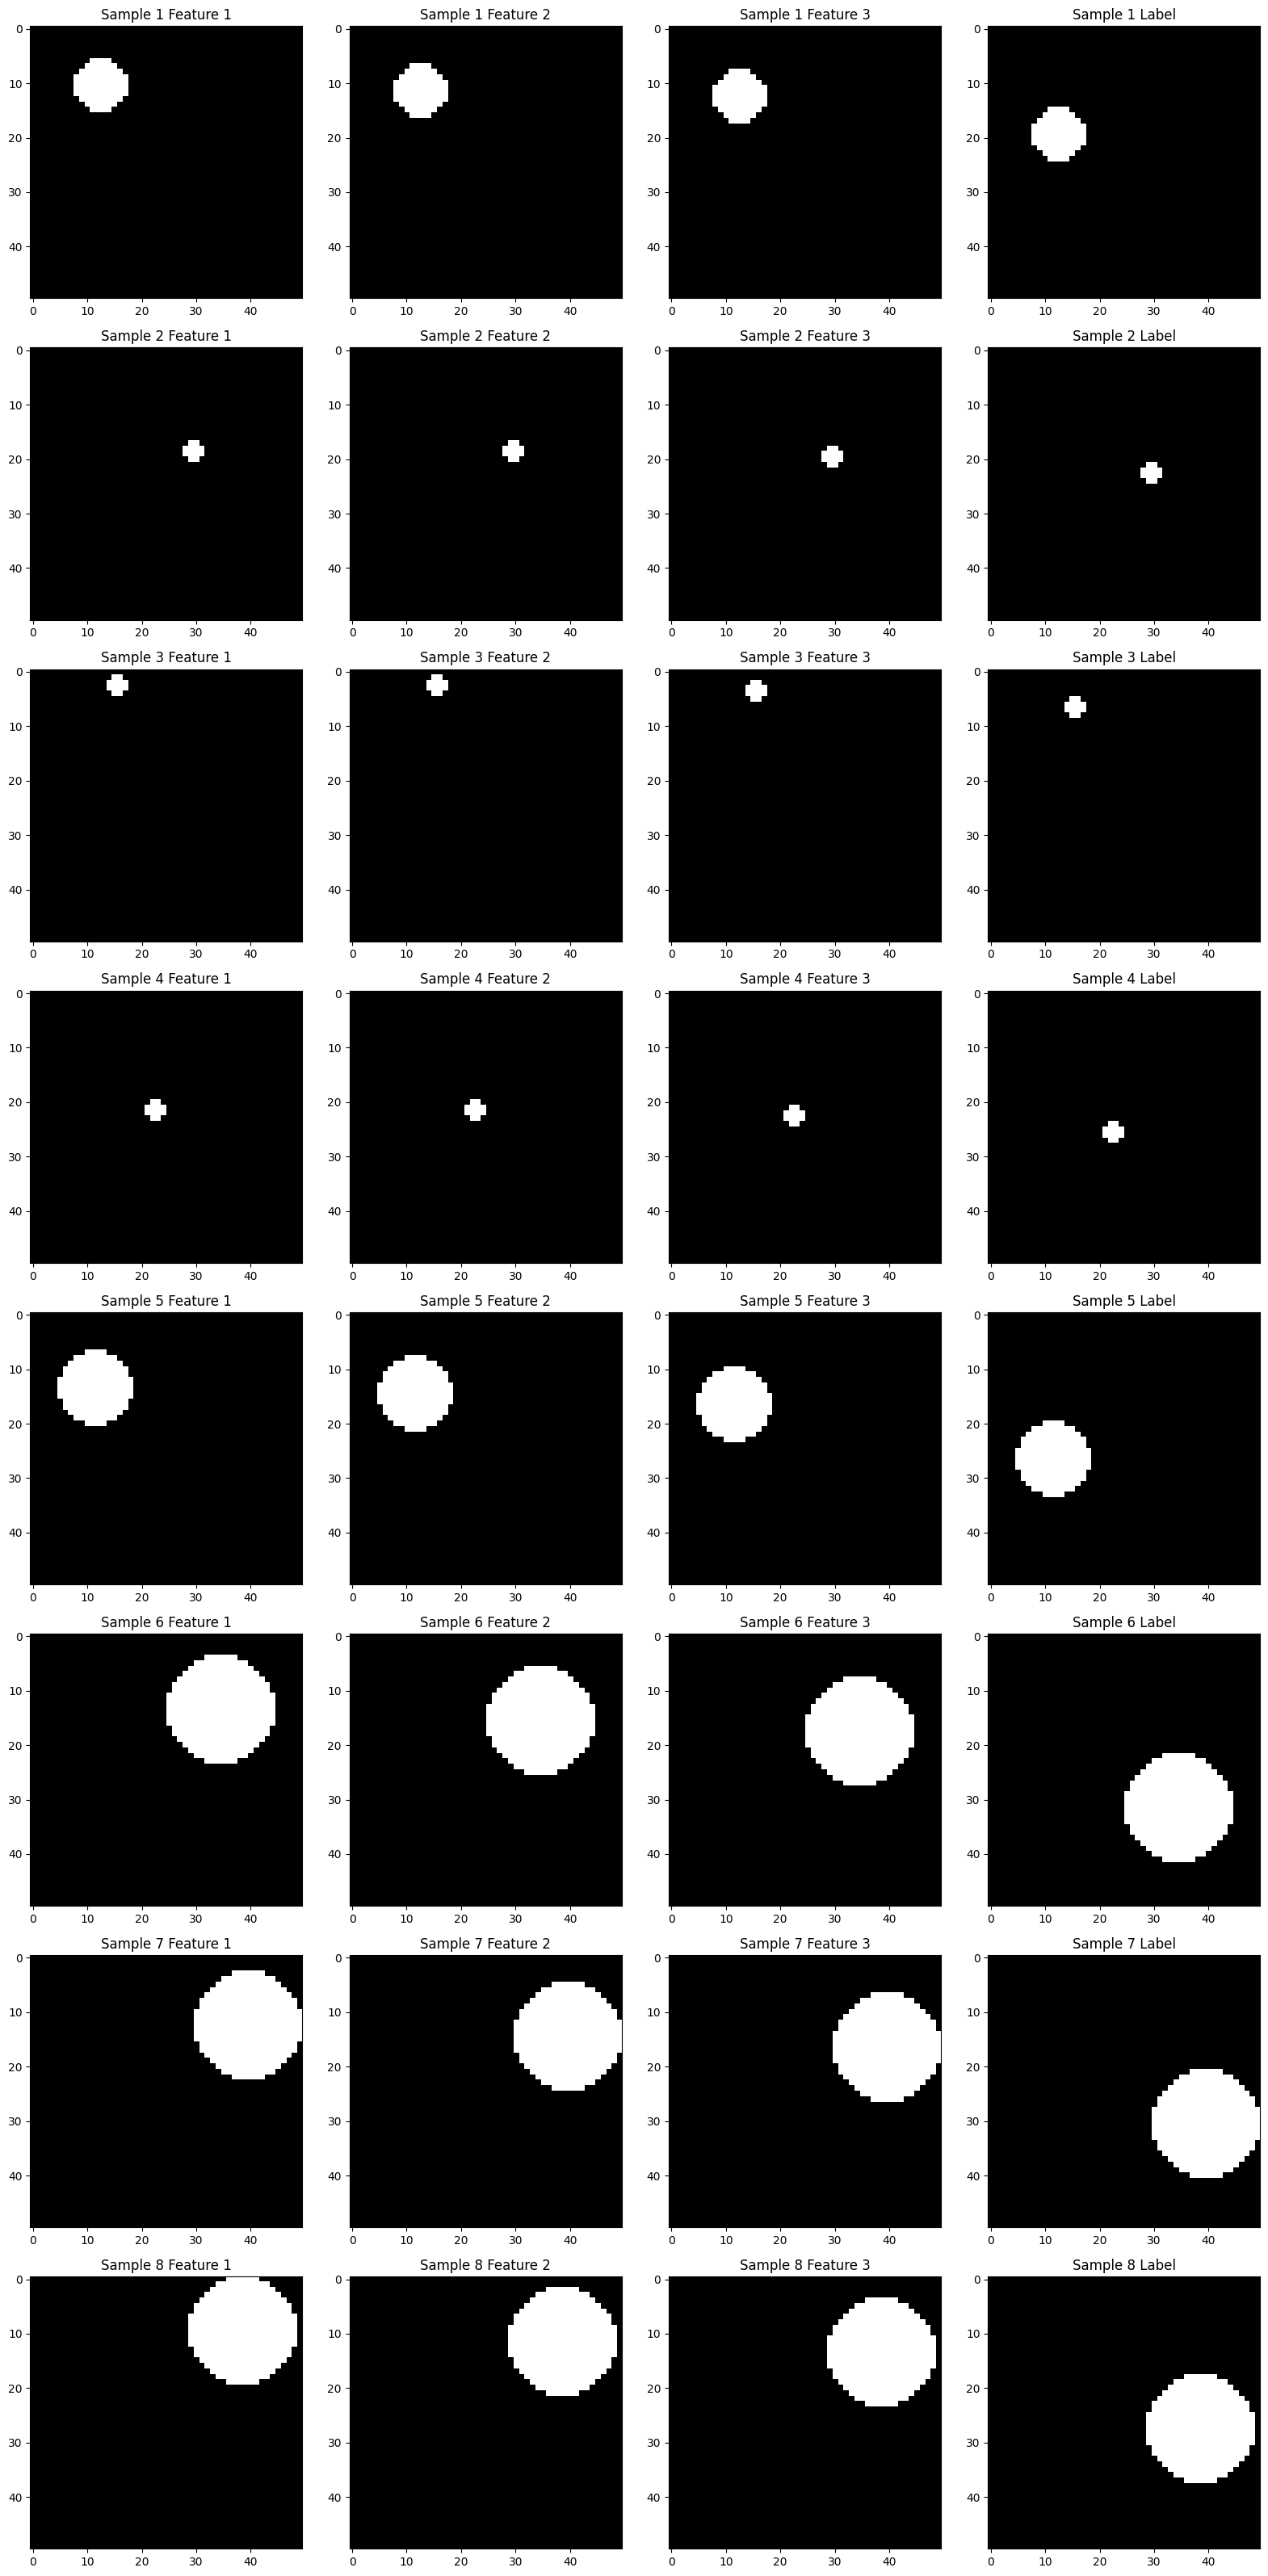

In [12]:
def visualize_samples(loader, num_samples=8):
    data_iter = iter(loader)
    features, labels = next(data_iter)
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples*4))  # 4 columns for 3 features + 1 label
    for i in range(num_samples):
        for j in range(3):  # 3 feature images
            axes[i, j].imshow(features[i, j].numpy().transpose(1, 2, 0), cmap='gray')
            axes[i, j].set_title(f"Sample {i+1} Feature {j+1}")

        # Displaying the label
        axes[i, 3].imshow(labels[i].numpy().transpose(1, 2, 0), cmap='gray')
        axes[i, 3].set_title(f"Sample {i+1} Label")
    plt.tight_layout()
    plt.show()

visualize_samples(train_loader)


In [13]:
#for training of any model
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    corrects = 0.0
    for batch in train_loader:
        data, target = batch
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == target.data)
    return total_loss / len(train_loader.dataset)#, corrects.double() / len(train_loader.dataset)

In [14]:
#for validation dataset
def validate(model, valid_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    corrects = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            data, target = batch
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == target.data)
    return total_loss / len(valid_loader.dataset)#, corrects.double() / len(valid_loader.dataset)

In [30]:
class CompactModel(nn.Module):
    def __init__(self):
        super(CompactModel, self).__init__()
        
        # CNN Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 32 channels output
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Pooling layer
        
        # LSTM Layer
        self.lstm = nn.LSTM(25*25*32, 128, 1, batch_first=True)  # Flattened size after pooling
        
        # Fully Connected Layer
        self.fc = nn.Linear(128, 50*50)

    def forward(self, x):
        # Given the shape of x: [8, 3, 1, 50, 50]
        batch_size, sequence_length, channels, height, width = x.size()
        
        # Reshape x to collapse the sequence length and channel dimensions
        x = x.view(batch_size * sequence_length, channels, height, width)
        
        # CNN Layers
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # Prepare for LSTM
        x = x.view(batch_size, sequence_length, -1)
        
        # LSTM
        lstm_out, _ = self.lstm(x)
        
        # Use the last LSTM output for the fully connected layer
        x = lstm_out[:, -1, :]
        x = self.fc(x)
        
        return x.view(batch_size, 1, 50, 50)  # Reshape back to image format




In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CompactModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3)


In [15]:
# Lists to collect losses and accuracies for each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

total_epochs = 0
total_time = 0

Epoch 1: Train Loss: 0.0076, Validation Loss: 0.0092
Epoch 2: Train Loss: 0.0076, Validation Loss: 0.0092
Epoch 3: Train Loss: 0.0076, Validation Loss: 0.0091
Epoch 4: Train Loss: 0.0076, Validation Loss: 0.0091
Epoch 5: Train Loss: 0.0076, Validation Loss: 0.0091
Epoch 6: Train Loss: 0.0076, Validation Loss: 0.0091
Epoch 7: Train Loss: 0.0075, Validation Loss: 0.0091
Epoch 8: Train Loss: 0.0075, Validation Loss: 0.0091
Epoch 9: Train Loss: 0.0075, Validation Loss: 0.0091
Epoch 10: Train Loss: 0.0075, Validation Loss: 0.0091
Epoch 11: Train Loss: 0.0075, Validation Loss: 0.0090
Epoch 12: Train Loss: 0.0075, Validation Loss: 0.0090
Epoch 13: Train Loss: 0.0075, Validation Loss: 0.0090
Epoch 14: Train Loss: 0.0074, Validation Loss: 0.0090
Epoch 15: Train Loss: 0.0074, Validation Loss: 0.0090
Epoch 16: Train Loss: 0.0074, Validation Loss: 0.0090
Epoch 17: Train Loss: 0.0074, Validation Loss: 0.0090
Epoch 18: Train Loss: 0.0074, Validation Loss: 0.0090
Epoch 19: Train Loss: 0.0074, Validat

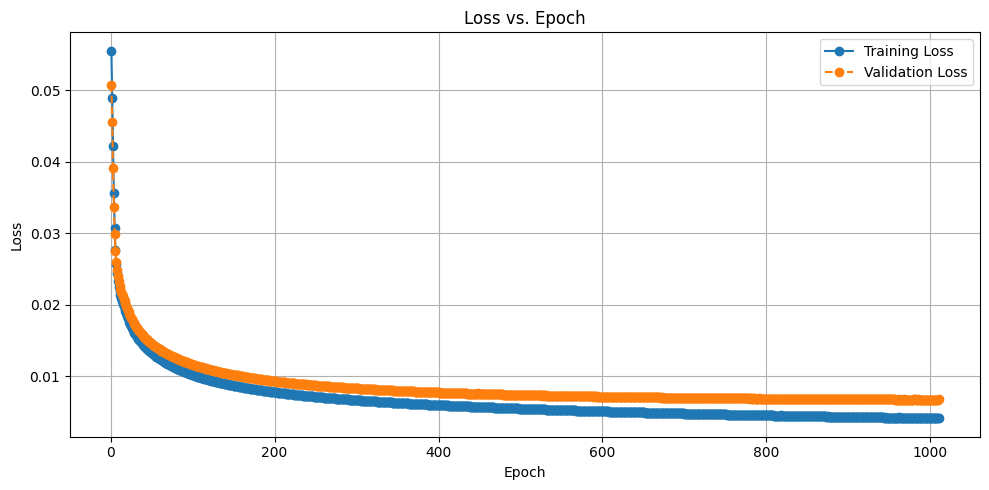

In [37]:
optimizer = torch.optim.SGD(model.parameters(), lr=3)
for epoch in range(1, 801):
    start_time = time.time()

    train_loss = train(model, train_loader, criterion, optimizer, device)
    valid_loss = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    elapsed_time = time.time() - start_time
    total_time += elapsed_time

    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(10, 5))

# Loss plots
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


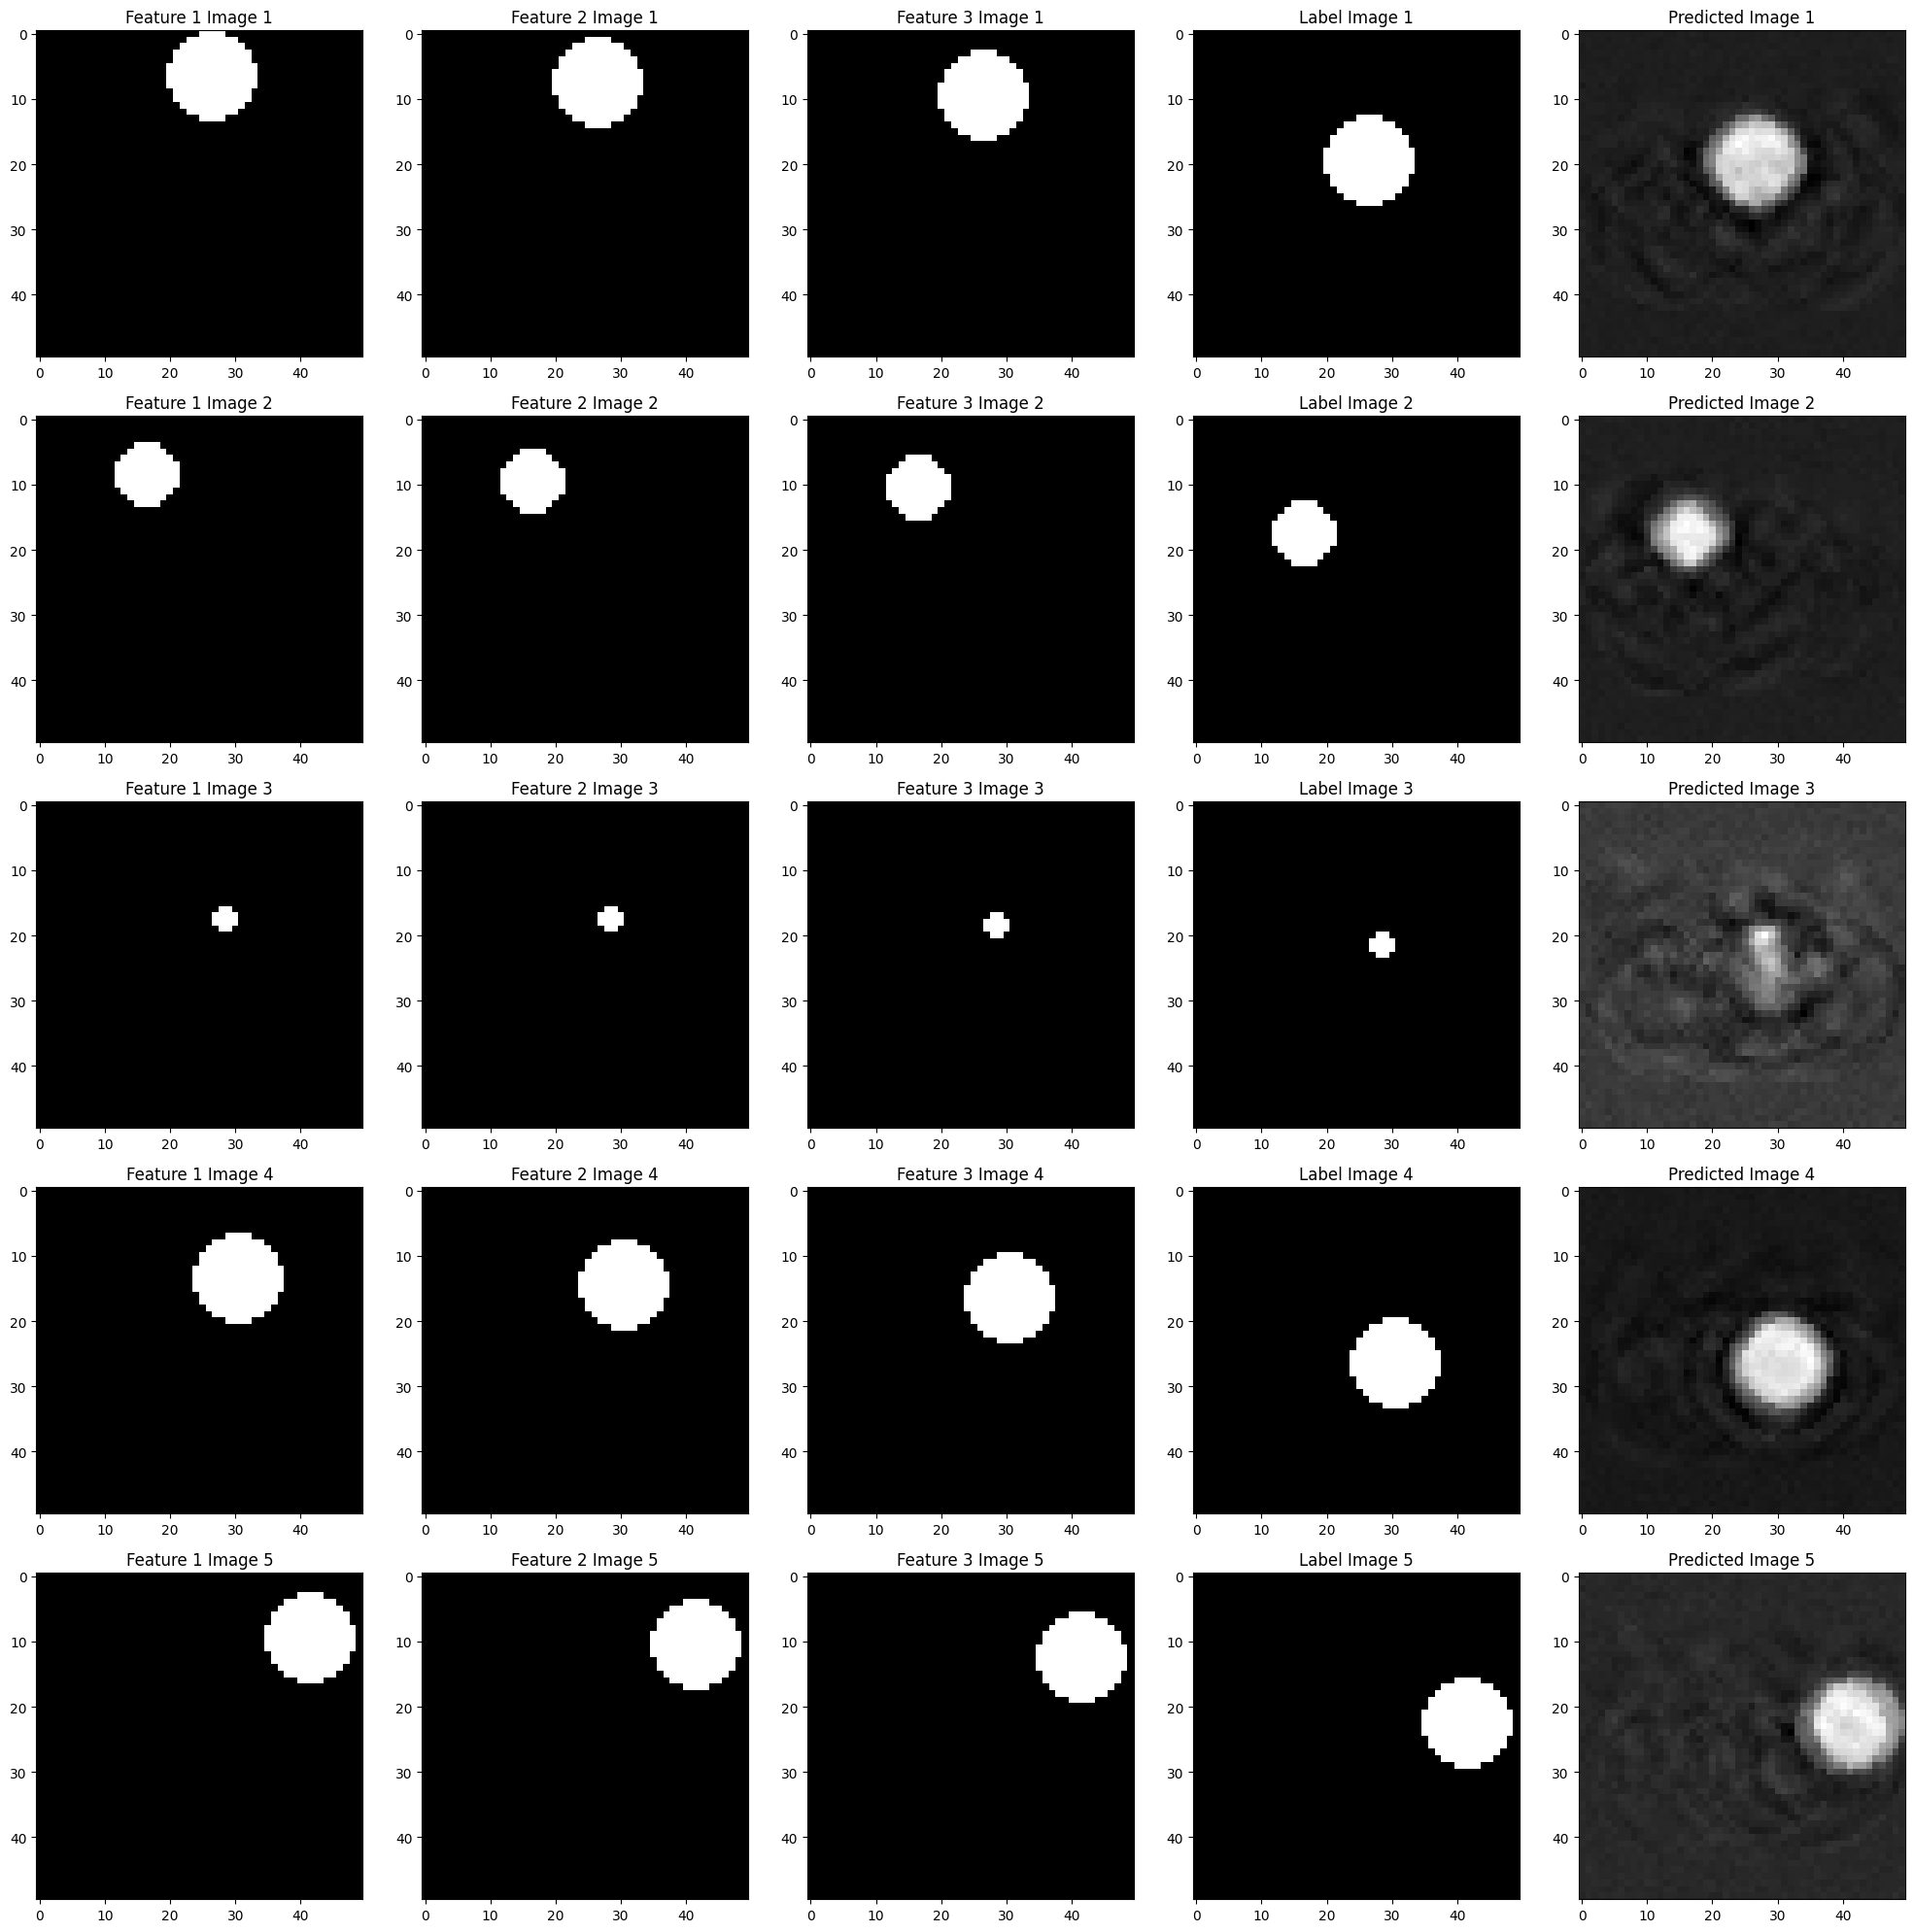

In [18]:
IMAGE_DIR = 'Mirai1_Data/Mirai1_3_data_timed_circles_1600'
def visualize_predictions(model, loader, num_samples=5):
    data_iter = iter(loader)
    features, labels = next(data_iter)

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(features.to(device))

    # Convert tensors to numpy arrays for visualization
    features = features.numpy()
    labels = labels.numpy()
    predictions = outputs.cpu().numpy()

    fig, axes = plt.subplots(num_samples, 5, figsize=(20, num_samples*4))  # 5 columns: 3 features, 1 label, 1 prediction
    for i in range(num_samples):
        for j in range(3):  # Display the 3 feature images
            axes[i, j].imshow(features[i, j].squeeze(), cmap='gray')
            axes[i, j].set_title(f"Feature {j+1} Image {i+1}")

        # Display the label
        axes[i, 3].imshow(labels[i].squeeze(), cmap='gray')
        axes[i, 3].set_title(f"Label Image {i+1}")

        # Display the prediction
        axes[i, 4].imshow(predictions[i].squeeze(), cmap='gray')
        axes[i, 4].set_title(f"Predicted Image {i+1}")

    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, test_loader)



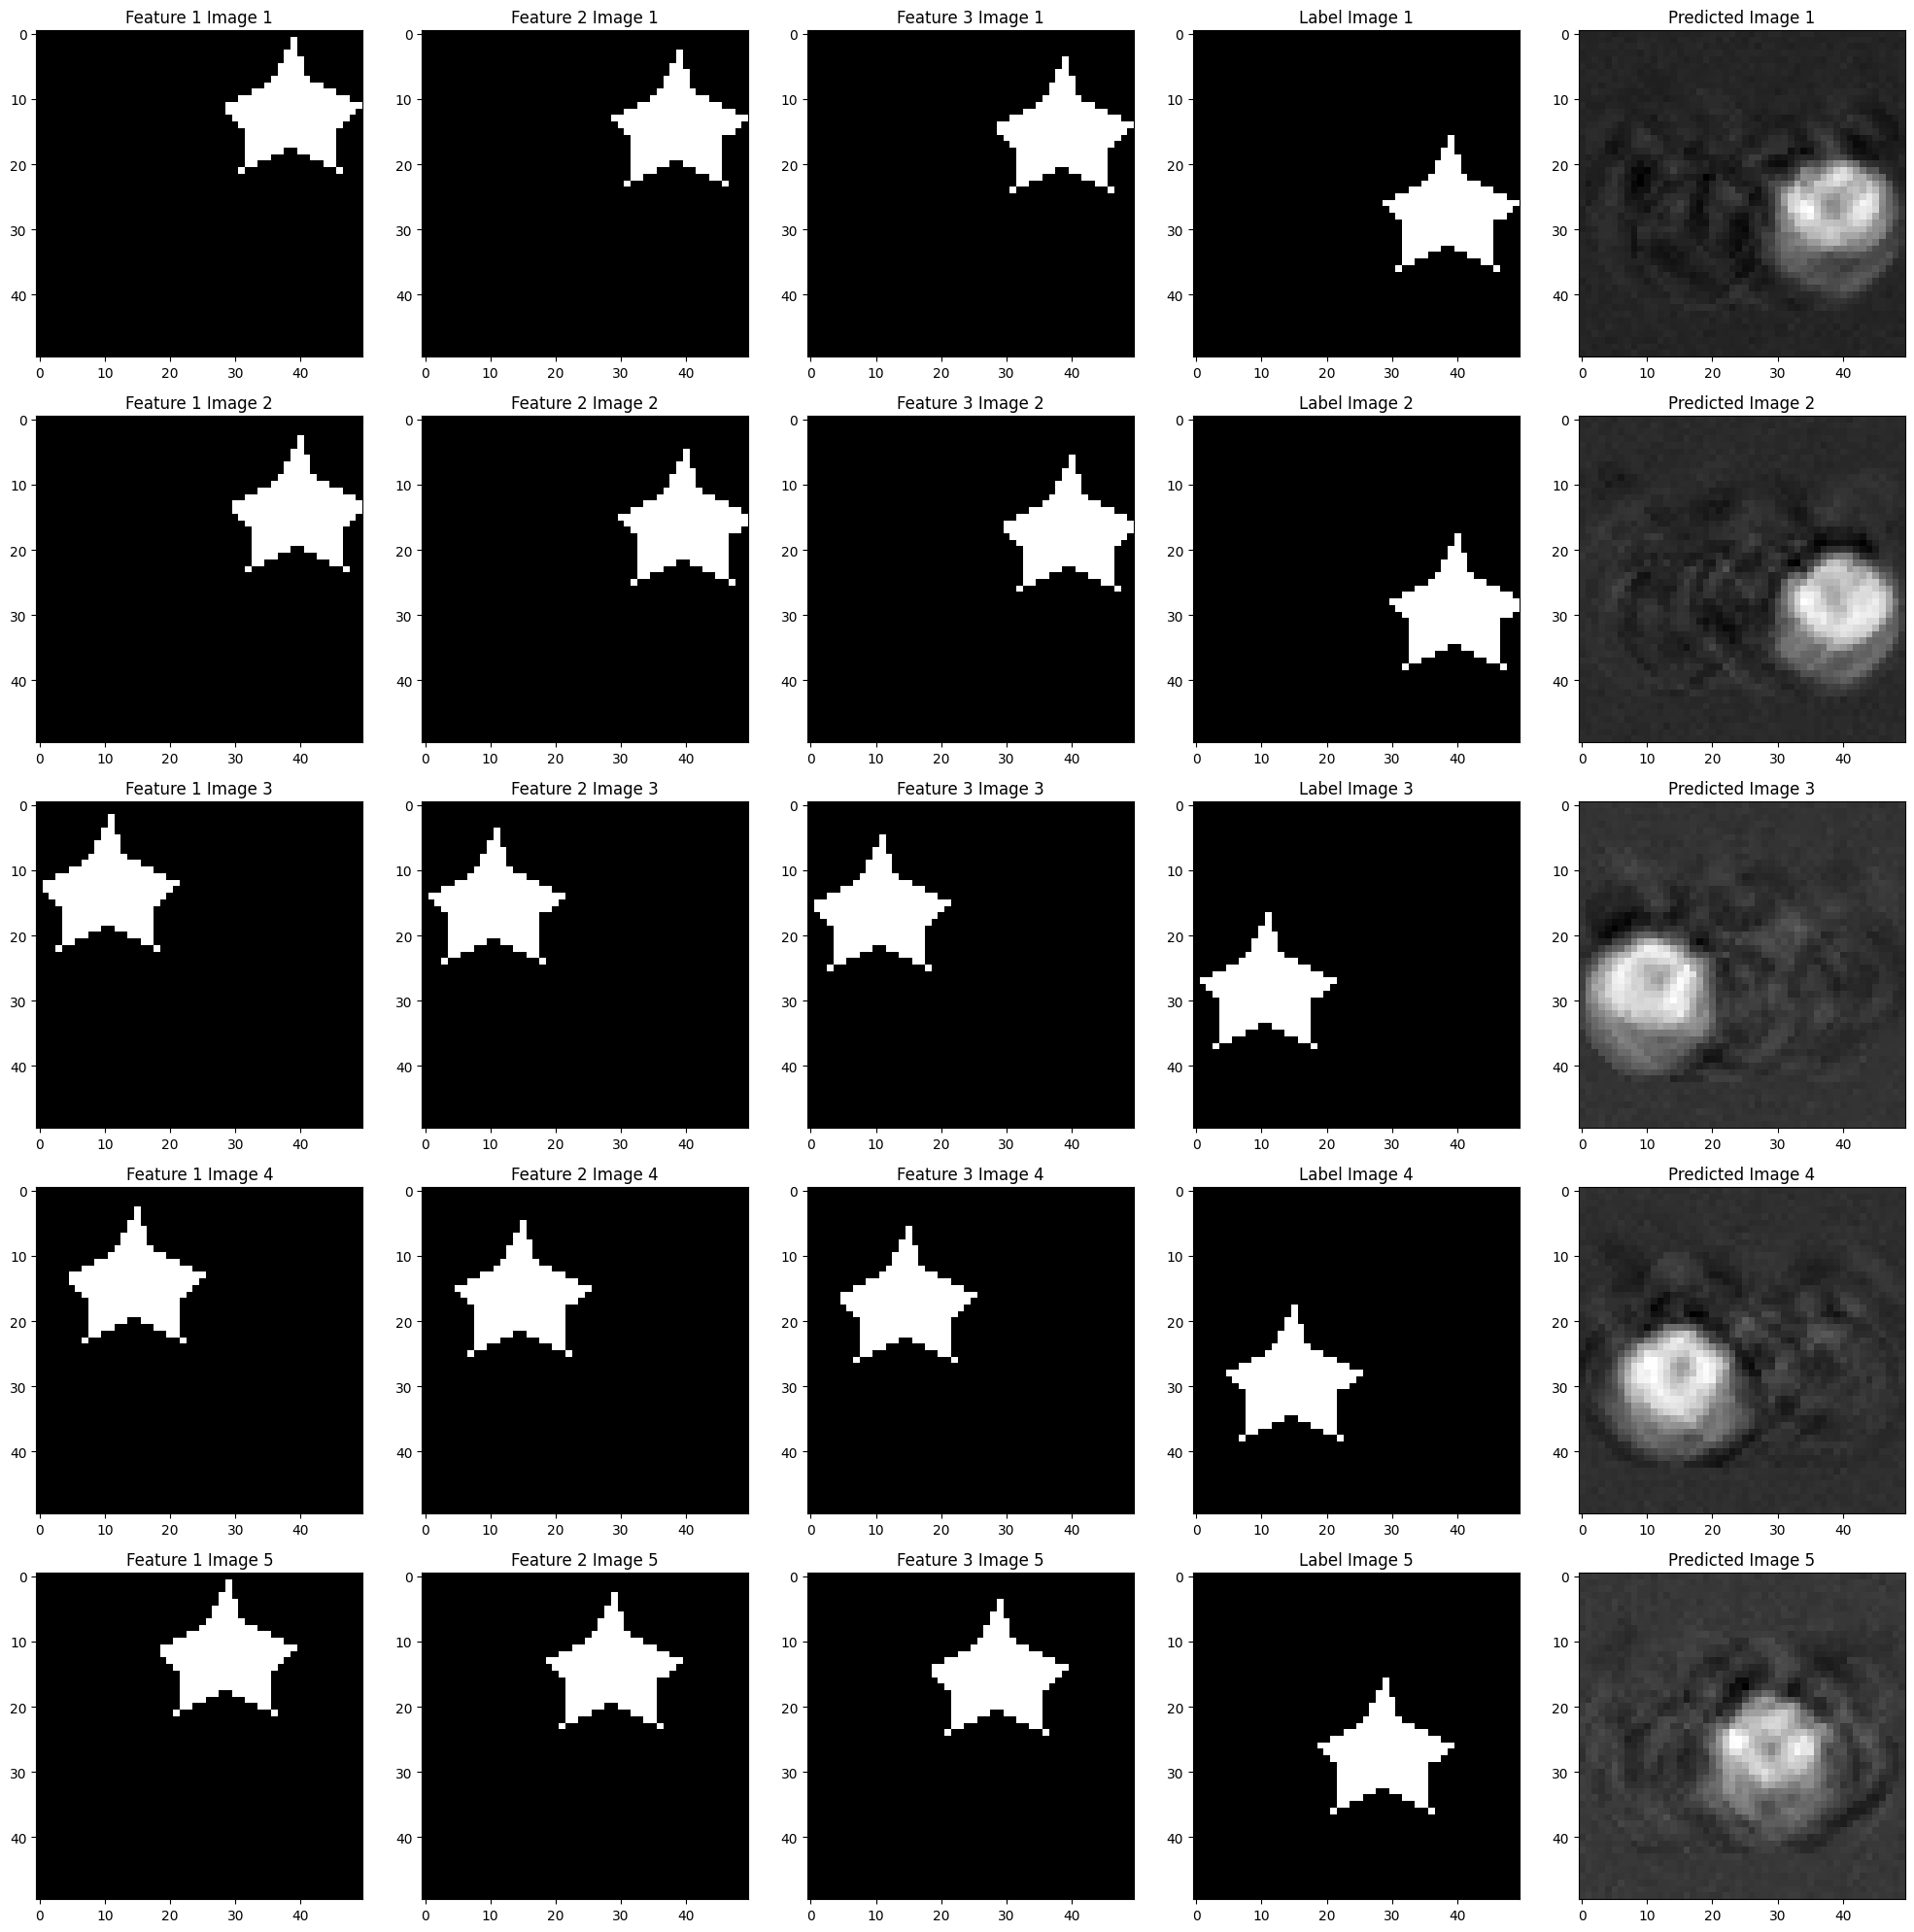

In [19]:
IMAGE_DIR = 'Mirai1_Data/Mirai1_3_data_timed_Star_8'

# List and sort the feature images
X1_images = sorted([img for img in os.listdir(IMAGE_DIR) if img.startswith('X_1')])
X2_images = sorted([img for img in os.listdir(IMAGE_DIR) if img.startswith('X_2')])
X3_images = sorted([img for img in os.listdir(IMAGE_DIR) if img.startswith('X_3')])
label_images = sorted([img for img in os.listdir(IMAGE_DIR) if img.startswith('Y')])

# Group feature images (X1_i, X2_i, X3_i)
feature_images = list(zip(X1_images, X2_images, X3_images))

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset_2 = CustomDataset(feature_images, label_images, transform=transform)
test_loader_2 = torch.utils.data.DataLoader(dataset_2, batch_size=5, shuffle=True)

visualize_predictions(model, test_loader_2)


In [13]:
class CompactModel(nn.Module):
    def __init__(self):
        super(CompactModel, self).__init__()
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(50*50, 1000)
        self.fc2 = nn.Linear(1000, 1000)

        # LSTM Layer
        self.lstm = nn.LSTM(1000, 128, 1, batch_first=True)
        
        # Fully Connected Layer for output
        self.fc3 = nn.Linear(128, 50*50)

    def forward(self, x):
        # Given the shape of x: [8, 3, 1, 50, 50]
        batch_size, sequence_length, channels, height, width = x.size()
        
        # Reshape x to collapse the sequence length and channel dimensions
        x = x.view(batch_size * sequence_length, channels * height * width)
        
        # Fully Connected Layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Prepare for LSTM
        x = x.view(batch_size, sequence_length, -1)
        
        # LSTM
        lstm_out, _ = self.lstm(x)
        
        # Use the last LSTM output for the fully connected layer
        x = lstm_out[:, -1, :]
        x = self.fc3(x)
        
        return x.view(batch_size, 1, 50, 50)  # Reshape back to image format


Epoch 1: Train Loss: 0.0494, Validation Loss: 0.0444
Epoch 2: Train Loss: 0.0349, Validation Loss: 0.0312
Epoch 3: Train Loss: 0.0267, Validation Loss: 0.0264
Epoch 4: Train Loss: 0.0236, Validation Loss: 0.0244
Epoch 5: Train Loss: 0.0219, Validation Loss: 0.0228
Epoch 6: Train Loss: 0.0207, Validation Loss: 0.0216
Epoch 7: Train Loss: 0.0198, Validation Loss: 0.0207
Epoch 8: Train Loss: 0.0188, Validation Loss: 0.0197
Epoch 9: Train Loss: 0.0180, Validation Loss: 0.0190
Epoch 10: Train Loss: 0.0173, Validation Loss: 0.0182
Epoch 11: Train Loss: 0.0167, Validation Loss: 0.0176
Epoch 12: Train Loss: 0.0162, Validation Loss: 0.0170
Epoch 13: Train Loss: 0.0157, Validation Loss: 0.0167
Epoch 14: Train Loss: 0.0153, Validation Loss: 0.0164
Epoch 15: Train Loss: 0.0149, Validation Loss: 0.0158
Epoch 16: Train Loss: 0.0146, Validation Loss: 0.0155
Epoch 17: Train Loss: 0.0143, Validation Loss: 0.0152
Epoch 18: Train Loss: 0.0140, Validation Loss: 0.0150
Epoch 19: Train Loss: 0.0138, Validat

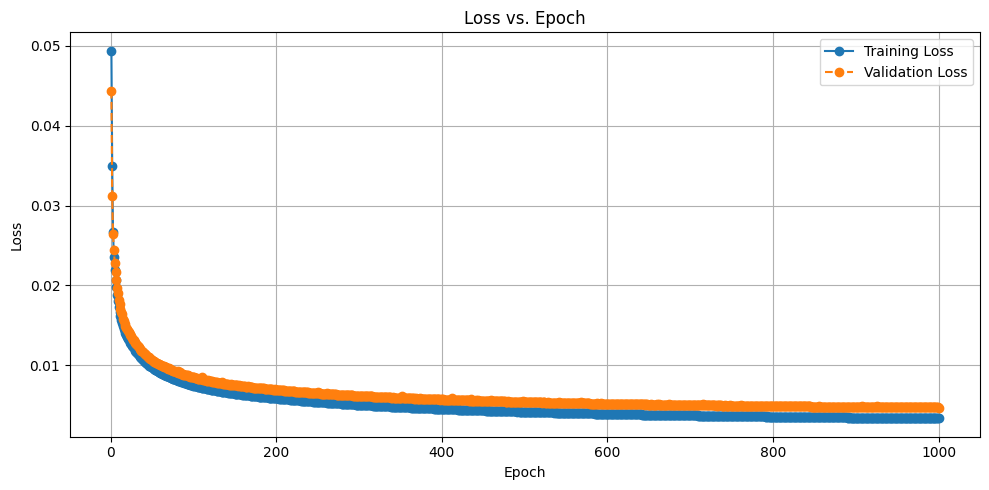

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=3)
for epoch in range(1, 1001):
    start_time = time.time()

    train_loss = train(model, train_loader, criterion, optimizer, device)
    valid_loss = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    elapsed_time = time.time() - start_time
    total_time += elapsed_time

    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(10, 5))

# Loss plots
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
